# FRET analysis

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [701]:
df1 = pd.read_csv('FRP-ex572-det-670sdt.sdt_data_trace.asc', sep=' ', names=['timestep', 'count', 'type'])
df2 = pd.read_csv('FRP_ex.572_det.670_2.sdt_data_trace.asc', sep=' ', names=['timestep', 'count', 'type'])
df3 = pd.read_csv('FRP_ex.572_det.670_3.sdt_data_trace.asc', sep=' ', names=['timestep', 'count', 'type'])
df4 = pd.read_csv('FRP-ex572-det-670-OCPsdt.sdt_data_trace.asc', sep=' ', names=['timestep', 'count', 'type'])
df5 = pd.read_csv('FRP-OCP_ex.572_det.670_2.sdt_data_trace.asc', sep=' ', names=['timestep', 'count', 'type'])
df6 = pd.read_csv('FRP-OCP_ex.572_det.670_3.sdt_data_trace.asc', sep=' ', names=['timestep', 'count', 'type'])
df7 = pd.read_csv('FRP-ex572-det-670-OCP-Rsdt.sdt_data_trace.asc', sep=' ', names=['timestep', 'count', 'type'])
df8 = pd.read_csv('FRP-OCPR_ex.572_det.670_2.sdt_data_trace.asc', sep=' ', names=['timestep', 'count', 'type'])
df9 = pd.read_csv('FRP-OCPR_ex.572_det.670_3.sdt_data_trace.asc', sep=' ', names=['timestep', 'count', 'type'])

df_list = [df1, df2, df3]
for df in df_list:
    df['type'] = 'FRP'

df_list = [df4, df5, df6]
for df in df_list:
    df['type'] = 'FRP-OCP'

df_list = [df7, df8, df9]
for df in df_list:
    df['type'] = 'FRP-OCP-R'

df_list = [df1,df2,df3,df4,df5,df6,df7,df8,df9]
df = pd.concat(df_list, axis = 0)
df['log'] = np.log1p(df['count'])
df['log'] = df['log']/df['log'].max()
df['count'] = df['count']/df['count'].max()

<Axes: xlabel='timestep', ylabel='count'>

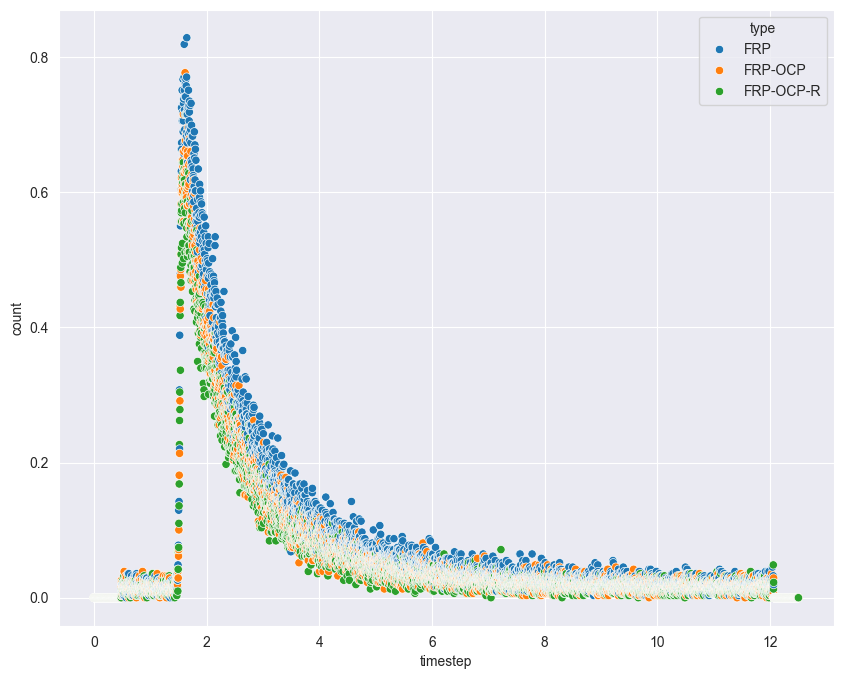

In [702]:
df = df.groupby(['timestep', 'type']).mean().reset_index()
plt.figure(figsize = (10,8))
sns.scatterplot(x='timestep', y='count', data=df, hue = 'type')

In [ ]:
def exp_model(x, a, b):
    # x0, y0 = timestep_max, count_max
    # a = y0/np.exp(-b*x0)
    return a * np.exp(-b * x)


def linear_model(x, k, b):
    # x0 = timestep_max
    return k * x + b


def exp_model2(x, a, b, c, d):
    # x0, y0 = timestep_max, count_max
    # a = y0/np.exp(-b*x0)
    return a * np.exp(-b * x) + c * np.exp(-d * x)

In [703]:
count_max = df['count'].max()
timestep_max = df[df['count'] == count_max]['timestep'].values[0]
x_data = np.unique(df[df['timestep'] >= timestep_max]['timestep'].to_numpy(dtype=float))


y_data_FRP = df[(df['timestep'] >= timestep_max) & (df['type'] == 'FRP')]['count'].to_numpy(dtype=float)
y_data_OCP = df[(df['timestep'] >= timestep_max) & (df['type'] == 'FRP-OCP')]['count'].to_numpy(dtype=float)
y_data_OCP_R = df[(df['timestep'] >= timestep_max) & (df['type'] == 'FRP-OCP-R')]['count'].to_numpy(dtype=float)
popt_FRP, _ = curve_fit(exp_model, x_data, y_data_FRP, maxfev = 10000)
popt_OCP, _ = curve_fit(exp_model2, x_data, y_data_OCP, maxfev = 10000)
popt_OCP_R, _ = curve_fit(exp_model2, x_data, y_data_OCP_R, maxfev = 10000)

y_fit_FRP = exp_model(np.unique(x_data), *popt_FRP)
y_fit_OCP = exp_model2(np.unique(x_data), *popt_OCP)
y_fit_OCP_R = exp_model2(np.unique(x_data), *popt_OCP_R)

/var/folders/3m/y_w236v57451r0pt2s2891000000gn/T/ipykernel_28201/1833195207.py:13: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c*np.exp(-d * x)
/var/folders/3m/y_w236v57451r0pt2s2891000000gn/T/ipykernel_28201/1833195207.py:13: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c*np.exp(-d * x)


In [704]:
popt_OCP_1 = 1/popt_OCP[1]
popt_OCP_2 = 1/popt_OCP[3]
popt_OCP_R_1 = 1/popt_OCP_R[1]
popt_OCP_R_2 = 1/popt_OCP_R[3]
print(f'OCP: tau1={popt_OCP_1}, tau={popt_OCP_2}')
print(f'OCPR: tau1={popt_OCP_R_1}, tau={popt_OCP_R_2}')

OCP: tau1=4.693938733278321, tau=0.786805138317553
OCPR: tau1=0.8212536227330345, tau=5.0932704682075975


In [706]:
a_1_OCP, a_2_OCP = popt_OCP[0]/(popt_OCP[0] + popt_OCP[2]), popt_OCP[2]/(popt_OCP[0] + popt_OCP[2])
a_1_OCP_R, a_2_OCP_R = popt_OCP_R[0]/(popt_OCP_R[0] + popt_OCP_R[2]), popt_OCP_R[2]/(popt_OCP_R[0] + popt_OCP_R[2])

theta_OCP = (a_1_OCP*popt_OCP_1 + a_2_OCP*popt_OCP_2).round(2)
theta_OCP_R = (a_1_OCP_R*popt_OCP_R_1 + a_2_OCP_R*popt_OCP_R_2).round(2)

print(f'OCP: a1={a_1_OCP}, a2={a_2_OCP}, theta={theta_OCP}')
print(f'OCP-R: a1={a_1_OCP_R}, a2={a_2_OCP_R}, theta={theta_OCP_R}')

OCP: a1=0.027503131104105714, a2=0.9724968688958943, theta=0.89
OCP-R: a1=0.9736909990725299, a2=0.026309000927470072, theta=0.93


In [707]:
tau_FRP = (1/popt_FRP[1]).round(2)

Text(0.5, 0, 'Время, нс')

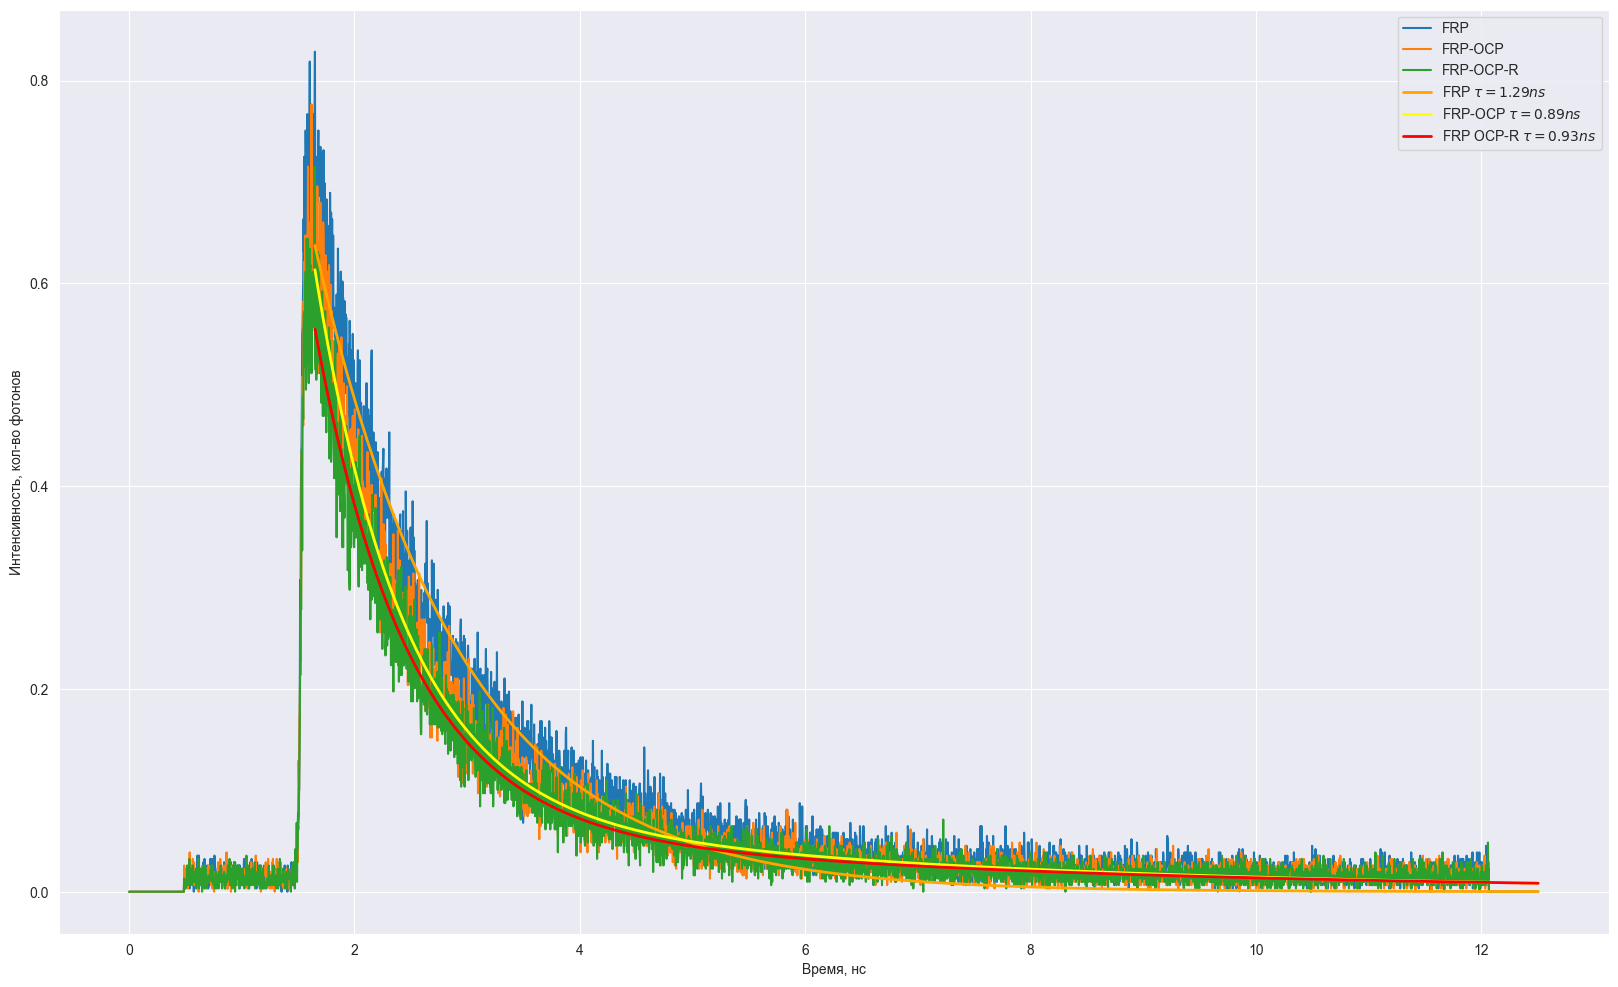

In [708]:
plt.figure(figsize = (20,12))

sns.lineplot(x='timestep', y='count', data=df, c = 'blue', hue = 'type')
plt.plot(np.unique(x_data), y_fit_FRP, color= 'orange', linewidth = 2, label = rf'FRP $\tau = {tau_FRP} ns$')
plt.plot(np.unique(x_data), y_fit_OCP, color= 'yellow', linewidth = 2, label = rf'FRP-OCP $\tau = {theta_OCP} ns$')
plt.plot(np.unique(x_data), y_fit_OCP_R, color= 'red', linewidth = 2, label = rf'FRP OCP-R $\tau = {theta_OCP_R} ns$')

plt.legend()
plt.ylabel('Интенсивность, кол-во фотонов')
plt.xlabel('Время, нс')
# plt.savefig('plots/inter.png', dpi = 600)

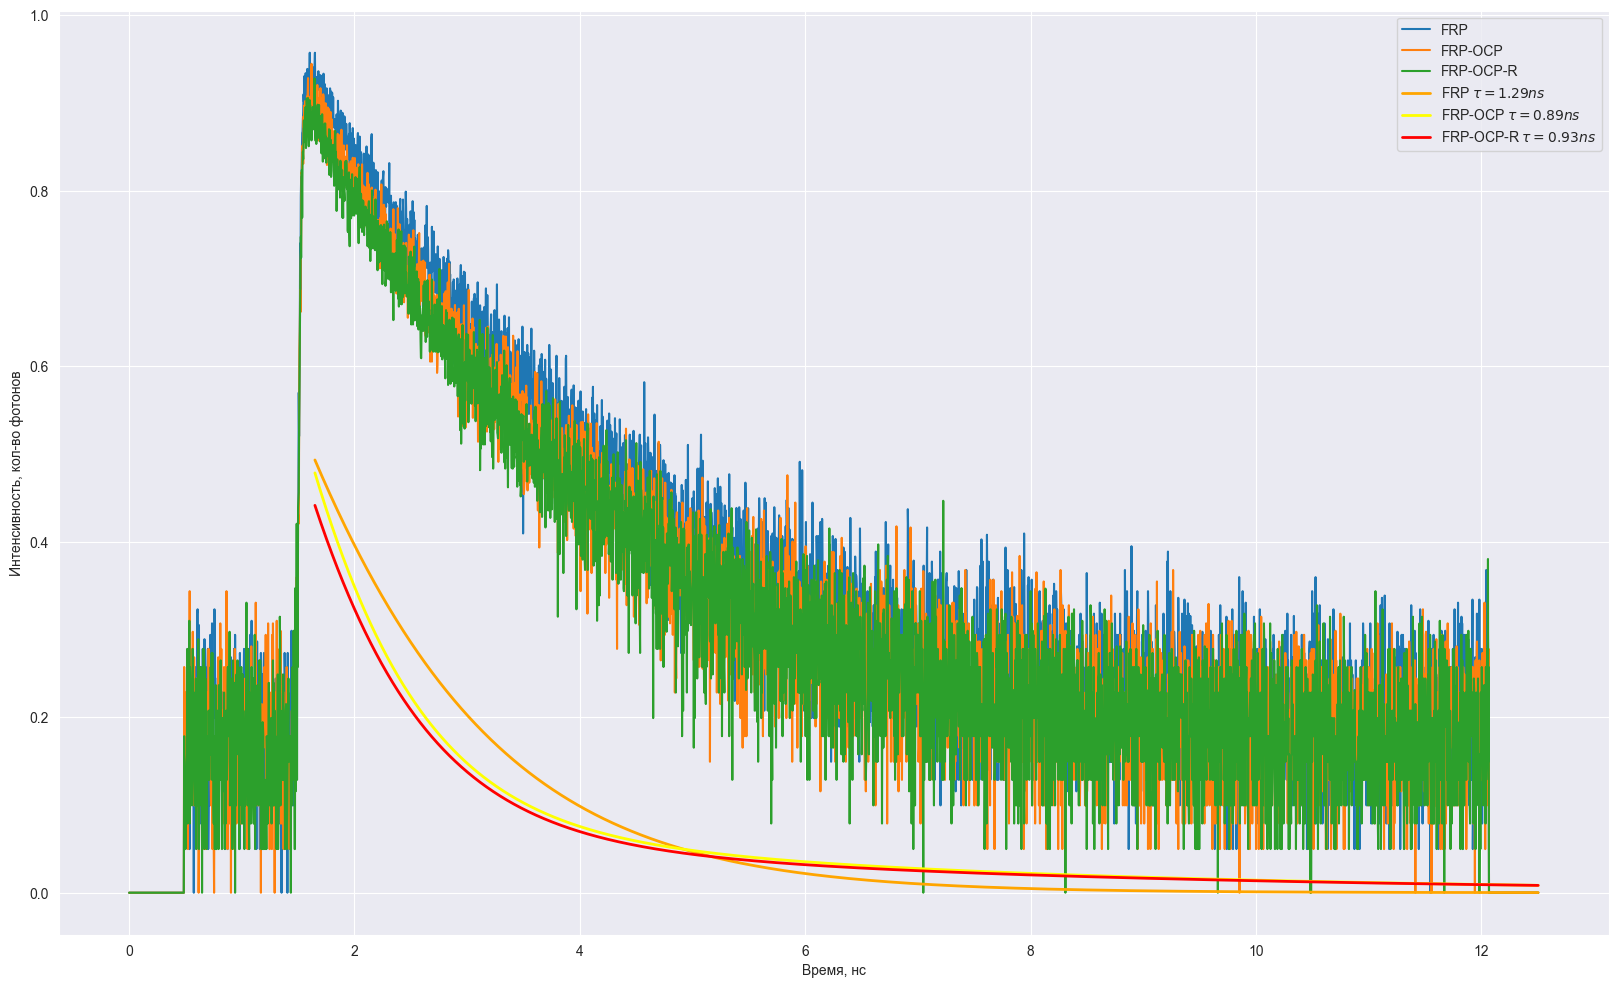

In [711]:
plt.figure(figsize = (20,12))

sns.lineplot(x='timestep', y='log', data=df, c = 'blue', hue = 'type')
plt.plot(np.unique(x_data), np.log1p(y_fit_FRP), color= 'orange', linewidth = 2, label = rf'FRP $\tau = {tau_FRP} ns$')
plt.plot(np.unique(x_data), np.log1p(y_fit_OCP), color= 'yellow', linewidth = 2, label = rf'FRP-OCP $\tau = {theta_OCP} ns$')
plt.plot(np.unique(x_data), np.log1p(y_fit_OCP_R), color= 'red', linewidth = 2, label = rf'FRP-OCP-R $\tau = {theta_OCP_R} ns$')

plt.legend()
plt.ylabel('Интенсивность, кол-во фотонов')
plt.xlabel('Время, нс')
plt.savefig('plots/inter_log.png', dpi = 600)